In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost

pd.set_option('display.max_columns', 1000)

In [76]:
home_to_away_model_data = pd.read_csv("data_preprocessed/home_to_away_model_data.csv", sep=";", index_col=0)
away_to_home_model_data = pd.read_csv("data_preprocessed/away_to_home_model_data.csv", sep=";", index_col=0)

home_match_history_data = pd.read_csv("data_preprocessed/home_match_history_data.csv", sep=';', index_col=0)
away_match_history_data = pd.read_csv("data_preprocessed/away_match_history_data.csv", sep=';', index_col=0)

In [77]:
model_data = pd.concat([home_to_away_model_data, away_to_home_model_data])
bet365_win_odds = pd.concat([home_to_away_model_data["Bet365_home_win_odds"], away_to_home_model_data["Bet365_away_win_odds"]])
bet365_lose_odds = pd.concat([away_to_home_model_data["Bet365_away_win_odds"], home_to_away_model_data["Bet365_home_win_odds"]])
model_data["Bet365_win_odds"] = bet365_win_odds
model_data["Bet365_lose_odds"] = bet365_lose_odds
model_data["Bet365_win_lose_ratio"] = model_data["Bet365_win_odds"] / model_data["Bet365_lose_odds"]
model_data["Bet365_win_draw_ratio"] = model_data["Bet365_win_odds"] / model_data["Bet365_draw_odds"]
model_data["Bet365_lose_draw_ratio"] = model_data["Bet365_lose_odds"] / model_data["Bet365_draw_odds"]
model_data = model_data.drop(columns=["Bet365_home_win_odds", "Bet365_away_win_odds"])

model_data

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

match_id  Bet365_draw_odds       elo  MF_Age_max  MF_Age_min  \
0        home_1              3.80       NaN    1.000000    1.125000   
1        home_2              4.20  0.838574    1.000000    0.941176   
2        home_3              4.50  1.063463    1.000000    1.222222   
3        home_4              4.33  1.106587    0.975000    1.111111   
4        home_5              3.20  0.942414    0.970588    0.888889   
...         ...               ...       ...         ...         ...   
4528  away_4529              3.20  1.053933    1.107143    1.000000   
4529  away_4530              3.20  1.036753    1.000000    0.904762   
4530  away_4531              3.20  1.030330    1.031250    0.900000   
4531  away_4532              3.10  0.961754    1.093750    1.000000   
4532  away_4533              3.25       NaN    0.941176    1.000000   

      MF_90s_max  MF_90s_min  MF_Tackles_Tkl_max  MF_Tackles_Tkl_min  \
0       0.489583        1.25            1.142857                 NaN   
1       0.769231        0.00           11.625000                 0.0   
2       0.633333        3.00            0.163636                 inf   
3       1.090909         inf           12.250000                 inf   
4       0.652174        0.00           10.333333                 NaN   
...          ...         ...                 ...                 ...   
4528    1.011494        0.00            1.500000                 NaN   
4529    2.540230         inf            0.777778                 NaN   
4530    0.988372        5.00            0.888889                 NaN   
4531    0.886598        7.00            0.128571                 NaN   
4532    1.064516        0.00            0.777778                 NaN   

      MF_Tackles_TklW_max  MF_Tackles_TklW_min  MF_Tackles_Def_3rd_max  \
0                1.000000                  NaN                1.125000   
1                1.000000                  NaN                1.285714   
2                1.285714                  inf                0.375000   
3                1.285714                  inf                1.800000   
4                0.888889                  NaN                1.800000   
...                   ...                  ...                     ...   
4528             0.625000                  NaN                1.125000   
4529             0.625000                  NaN                1.000000   
4530             0.857143                  NaN                1.125000   
4531             1.000000                  NaN                1.125000   
4532             1.000000                  NaN                0.857143   

      MF_Tackles_Def_3rd_min  MF_Tackles_Mid_3rd_max  MF_Tackles_Mid_3rd_min  \
0                        NaN                0.750000                     NaN   
1                        NaN                0.888889                     NaN   
2                        NaN                0.888889                     inf   
3                        inf                1.000000                     inf   
4                        NaN                1.333333                     NaN   
...                      ...                     ...                     ...   
4528                     NaN                1.000000                     NaN   
4529                     NaN                0.750000                     NaN   
4530                     NaN                1.400000                     NaN   
4531                     NaN                0.777778                     NaN   
4532                     NaN                1.125000                     NaN   

      MF_Tackles_Att_3rd_max  MF_Tackles_Att_3rd_min  MF_Challenges_Tkl_max  \
0                   1.166667                     NaN               1.000000   
1                   1.000000                     NaN               1.142857   
2                   0.857143                     NaN               0.666667   
3                   1.200000                     NaN               0.777778   
4                   1.500000                

In [78]:
target_colnames = ['match_id', 'Goals', 'Shots_on_Target', 'Win', 'Draw']

# Rename columns
home_match_history_data.columns = target_colnames
away_match_history_data.columns = target_colnames

target_data = pd.concat([home_match_history_data, away_match_history_data])

target_data

,match_id,Goals,Shots_on_Target,Win,Draw
0,home_1,0,4,0,0
1,home_2,0,3,0,0
2,home_3,1,2,1,0
3,home_4,3,10,1,0
4,home_5,1,2,0,0
...,...,...,...,...,...
4708,away_4529,2,5,1,0
4709,away_4530,1,2,1,0
4710,away_4531,2,3,1,0
4711,away_4532,0,3,0,0


# Model data preprocessing

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import shap
import matplotlib.pyplot as plt

from hyperopt import hp
import hyperopt
import csv
from datetime import datetime
import pickle

#### Remove null columns

In [80]:
model_data = model_data.loc[:, ~model_data.isna().all()]

#### Replace np.inf with np.nan

In [81]:
model_data.replace([np.inf, -np.inf], np.nan, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Remove columns with > 80% of NaNs

In [82]:
model_data = model_data.loc[:, ~((model_data.isna().sum() / model_data.shape[0]) > 0.8)]

# Filter out away match_id

In [104]:
model_data = model_data[model_data["match_id"].str.startswith("home")]
target_data = target_data[target_data["match_id"].str.startswith("home")]

# Model utils

In [105]:
def global_shap_importance(shap_values):
    """Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=["features", "importance"]
    )
    feature_importance.sort_values(by=["importance"], ascending=False, inplace=True)
    return feature_importance


xgb_classifier_space = {
    "booster": hp.choice("booster", ["gbtree"]),
    "eta": hp.uniform("eta", 0.01, 0.5),
    "max_depth": hp.choice("max_depth", np.arange(2, 8, dtype=int)),
    "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0),
    "gamma": hp.uniform("gamma", 0, 1.0),
    "lambda": hp.uniform("lambda", 1, 2),
    "alpha": hp.uniform("alpha", 0, 2),
    "n_estimators": hp.choice("n_estimators", np.arange(50, 1200, 50, dtype=int)),
    "early_stopping_rounds": hp.choice(
        "early_stopping_rounds", np.arange(30, 40, 5, dtype=int)
    ),
}

# Model pipeline

In [109]:
def model_pipeline(
    target_column,
    model_data=model_data,
    target_data=target_data,
    n_features=100,
    xgb_classifier_space=xgb_classifier_space,
    penalty_factor=0.5,
    hp_max_evals=100,
):
    """Model pipeline: train-test split, shortlist, hyperopt, assessment"""

    # Train-test data split
    model_data = model_data.reset_index(drop=True)
    target_data = target_data.reset_index(drop=True)

    X_train, X_test, y_train, y_test = train_test_split(
        model_data, target_data, test_size=0.2, random_state=42
    )

    X_train = X_train.drop(columns=["match_id"])
    X_test = X_test.drop(columns=["match_id"])
    y_train = y_train[target_column]
    y_test = y_test[target_column]

    # Create shortlist based of SHAP
    shortlist_model = xgboost.XGBClassifier(
        objective="binary:logistic",
        scale_pos_weight=np.mean(y_train),
        booster="gbtree",
        verbosity=1,
        nthread=-1,
        eta=0.3,
        max_depth=7,
        min_child_weight=1,
        subsample=1,
        colsample_bytree=1,
        early_stopping_rounds=50,
        n_estimators=500,
        tree_method="hist",
    )

    # Fit the model to the training data
    shortlist_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # Make predictions on the testing data
    y_train_pred = shortlist_model.predict(X_train)
    y_test_pred = shortlist_model.predict(X_test)

    # Evaluate the model performance
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    print("Accuracy train:", accuracy_train)
    print("Accuracy test:", accuracy_test)

    # Create shortlist based of SHAP
    # Calculate SHAP values for a set of examples
    explainer = shap.Explainer(shortlist_model)
    shap_values = explainer(X_train)

    # Plot the SHAP values for the first example
    plt.style.use('default')
    shap.summary_plot(shap_values, X_train, show=False)
    plt.savefig(f'model/SHAP_shortlist_{target_column}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', bbox_inches='tight')

    #### Select TOP features
    # SHAP features
    shap_shortlist = list(
        global_shap_importance(shap_values)["features"][:n_features].values
    )

    X_train_shortlist = X_train[shap_shortlist]
    X_test_shortlist = X_test[shap_shortlist]

    # Create dev-val datasets from train for model training
    X_dev_shortlist, X_val_shortlist, y_dev, y_val = train_test_split(
        X_train_shortlist, y_train, test_size=0.3, random_state=42
    )

    # Final model
    def _gini(model, y, X):
        pred = model.predict_proba(X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1)
        gini = 2 * auc(fpr, tpr) - 1
        return gini

    def _acc(model, y, X):
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        return accuracy

    def _objective(params):
        model = xgboost.XGBClassifier(
            **params,
            scale_pos_weight=np.mean(y_dev.values),
            tree_method="hist",
            nthread=-1,
        )
        model.fit(
            X_dev_shortlist.values,
            y_dev.values,
            verbose=0,
            eval_set=[(X_val_shortlist.values, y_val.values)],
        )
        gini_train = _gini(model, y_dev.values, X_dev_shortlist)
        gini_test = _gini(model, y_val.values, X_val_shortlist)
        score = -gini_test + penalty_factor * abs(gini_train - gini_test)
        return score

    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        verbose=0,
        fn=_objective,
        space=xgb_classifier_space,
        algo=hyperopt.tpe.suggest,
        max_evals=hp_max_evals,
        trials=trials,
    )

    # Save trials log
    with open(
        f'model/hp_trials_{target_column}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv',
        "w",
        newline="",
    ) as file:
        writer = csv.DictWriter(file, fieldnames=trials.trials[0]["result"].keys())
        writer.writeheader()
        for trial in trials.trials:
            result = trial["result"]
            result["misc"] = str(trial["misc"])
            writer.writerow(result)

    # Get the best model
    best_params = hyperopt.space_eval(xgb_classifier_space, best)
    print(best_params)
    model_final = xgboost.XGBClassifier(**best_params).fit(
        X_dev_shortlist.values,
        y_dev.values,
        eval_set=[(X_val_shortlist.values, y_val.values)],
    )

    # Save the model to a file
    setattr(model_final, "model_variables", X_dev_shortlist.columns.tolist())
    with open(
        f'model/hyperopt_model_{target_column}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl',
        "wb",
    ) as file:
        pickle.dump(model_final, file)

    # Model Assessment
    # Score dev
    print(f"Gini dev: {_gini(model_final, y_dev, X_dev_shortlist)}")
    print(f"Accuracy dev: {_acc(model_final, y_dev, X_dev_shortlist)}\n")

    # Score val
    print(f"Gini val: {_gini(model_final, y_val, X_val_shortlist)}")
    print(f"Accuracy val: {_acc(model_final, y_val, X_val_shortlist)}\n")

    # Score test
    print(f"Gini test: {_gini(model_final, y_test, X_test_shortlist)}")
    print(f"Accuracy test: {_acc(model_final, y_test, X_test_shortlist)}\n")

[0]	validation_0-logloss:0.64183
[1]	validation_0-logloss:0.62194
[2]	validation_0-logloss:0.60970
[3]	validation_0-logloss:0.60952
[4]	validation_0-logloss:0.60962
[5]	validation_0-logloss:0.61345
[6]	validation_0-logloss:0.61645
[7]	validation_0-logloss:0.62115
[8]	validation_0-logloss:0.62365
[9]	validation_0-logloss:0.62673
[10]	validation_0-logloss:0.62739
[11]	validation_0-logloss:0.62903
[12]	validation_0-logloss:0.63014
[13]	validation_0-logloss:0.63010
[14]	validation_0-logloss:0.63061
[15]	validation_0-logloss:0.63455
[16]	validation_0-logloss:0.63791
[17]	validation_0-logloss:0.64257
[18]	validation_0-logloss:0.64398
[19]	validation_0-logloss:0.64347
[20]	validation_0-logloss:0.64655
[21]	validation_0-logloss:0.64567
[22]	validation_0-logloss:0.64554
[23]	validation_0-logloss:0.64827
[24]	validation_0-logloss:0.64917
[25]	validation_0-logloss:0.65470
[26]	validation_0-logloss:0.65455
[27]	validation_0-logloss:0.65290
[28]	validation_0-logloss:0.65501
[29]	validation_0-loglos

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


{'alpha': 0.7349016661126718, 'booster': 'gbtree', 'colsample_bytree': 0.7216161406977062, 'early_stopping_rounds': 35, 'eta': 0.1570187343201878, 'gamma': 0.3818948586647483, 'lambda': 1.1827207170536163, 'max_depth': 2, 'min_child_weight': 8.0, 'n_estimators': 1150, 'subsample': 0.8126755931858369}
[0]	validation_0-logloss:0.66481
[1]	validation_0-logloss:0.64398
[2]	validation_0-logloss:0.62969
[3]	validation_0-logloss:0.61902
[4]	validation_0-logloss:0.60943
[5]	validation_0-logloss:0.60247
[6]	validation_0-logloss:0.59681
[7]	validation_0-logloss:0.59359
[8]	validation_0-logloss:0.59029
[9]	validation_0-logloss:0.58613
[10]	validation_0-logloss:0.58456
[11]	validation_0-logloss:0.58134
[12]	validation_0-logloss:0.58010
[13]	validation_0-logloss:0.57844
[14]	validation_0-logloss:0.57764
[15]	validation_0-logloss:0.57758
[16]	validation_0-logloss:0.57818
[17]	validation_0-logloss:0.57733
[18]	validation_0-logloss:0.57726
[19]	validation_0-logloss:0.57761
[20]	validation_0-logloss:0.

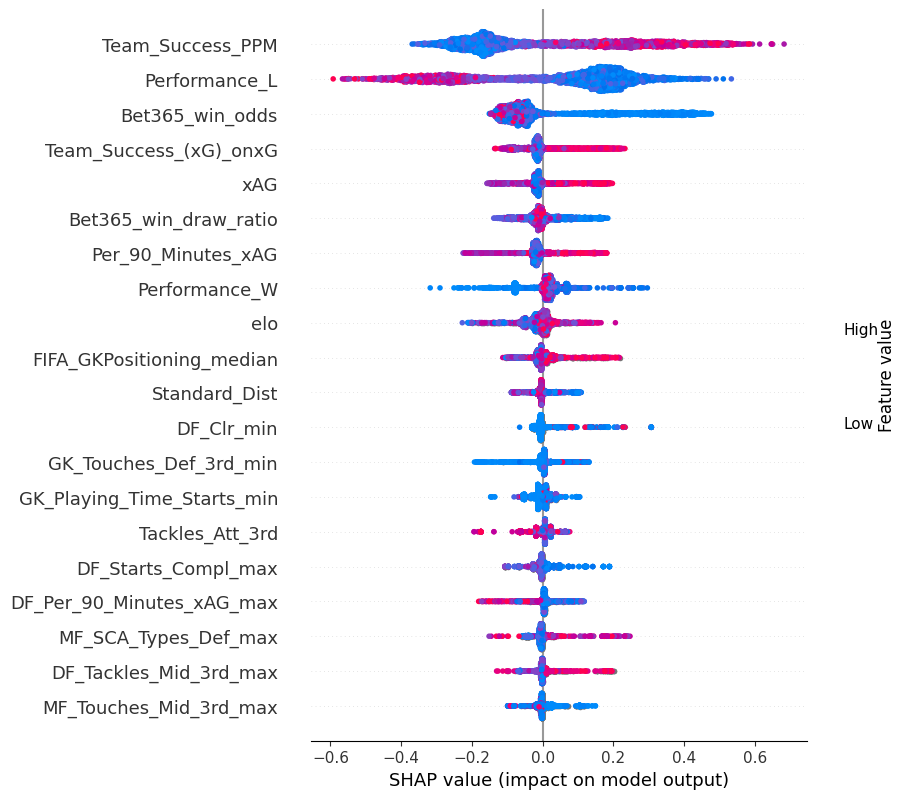

In [110]:
# Model 1 - Win classifier
model_pipeline(target_column="Win")

[0]	validation_0-logloss:0.60555
[1]	validation_0-logloss:0.58048
[2]	validation_0-logloss:0.57862
[3]	validation_0-logloss:0.59132
[4]	validation_0-logloss:0.61283
[5]	validation_0-logloss:0.63252
[6]	validation_0-logloss:0.65036
[7]	validation_0-logloss:0.66913
[8]	validation_0-logloss:0.67736
[9]	validation_0-logloss:0.68836
[10]	validation_0-logloss:0.69872
[11]	validation_0-logloss:0.70831
[12]	validation_0-logloss:0.71505
[13]	validation_0-logloss:0.72445
[14]	validation_0-logloss:0.73178
[15]	validation_0-logloss:0.73196
[16]	validation_0-logloss:0.73753
[17]	validation_0-logloss:0.74218
[18]	validation_0-logloss:0.74573
[19]	validation_0-logloss:0.74664
[20]	validation_0-logloss:0.74645
[21]	validation_0-logloss:0.74909
[22]	validation_0-logloss:0.75458
[23]	validation_0-logloss:0.75918
[24]	validation_0-logloss:0.76448
[25]	validation_0-logloss:0.76606
[26]	validation_0-logloss:0.76787
[27]	validation_0-logloss:0.76882
[28]	validation_0-logloss:0.77669
[29]	validation_0-loglos

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


{'alpha': 0.6086369475572113, 'booster': 'gbtree', 'colsample_bytree': 0.8519903711645016, 'early_stopping_rounds': 35, 'eta': 0.19531040145644646, 'gamma': 0.9339841187184479, 'lambda': 1.190702748444662, 'max_depth': 2, 'min_child_weight': 6.0, 'n_estimators': 100, 'subsample': 0.7366542916345639}
[0]	validation_0-logloss:0.64908
[1]	validation_0-logloss:0.62142
[2]	validation_0-logloss:0.60361
[3]	validation_0-logloss:0.59297
[4]	validation_0-logloss:0.58489
[5]	validation_0-logloss:0.57990
[6]	validation_0-logloss:0.57663
[7]	validation_0-logloss:0.57432
[8]	validation_0-logloss:0.57420
[9]	validation_0-logloss:0.57444
[10]	validation_0-logloss:0.57555
[11]	validation_0-logloss:0.57648
[12]	validation_0-logloss:0.57718
[13]	validation_0-logloss:0.57758
[14]	validation_0-logloss:0.57959
[15]	validation_0-logloss:0.58102
[16]	validation_0-logloss:0.58220
[17]	validation_0-logloss:0.58270
[18]	validation_0-logloss:0.58255
[19]	validation_0-logloss:0.58273
[20]	validation_0-logloss:0.5

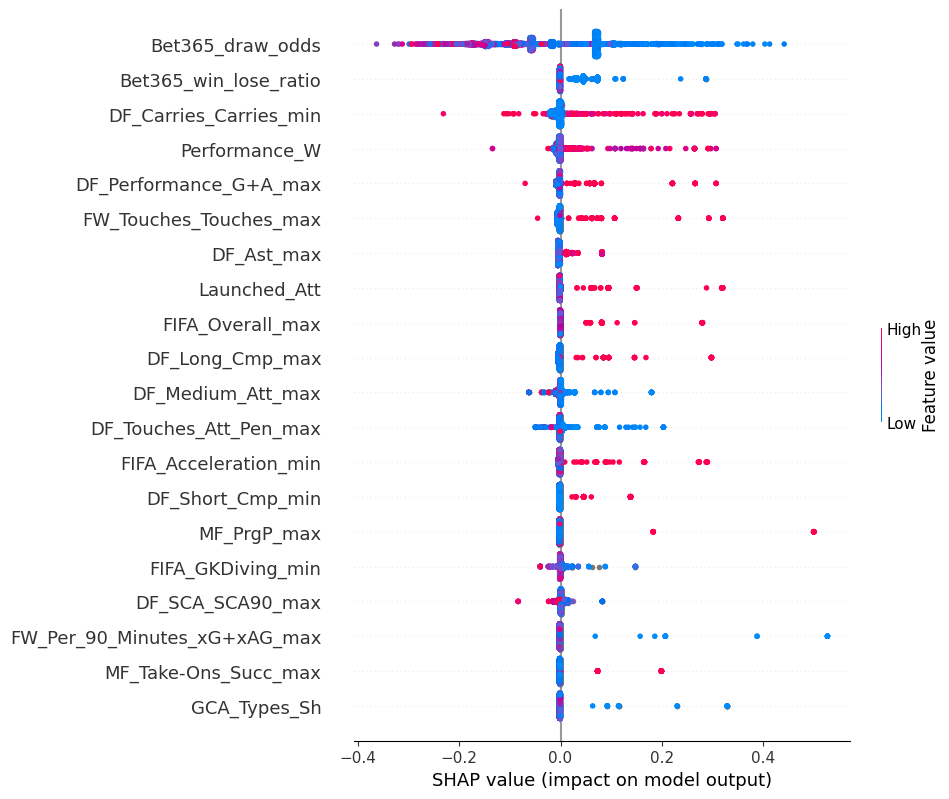

In [111]:
# Model 2 - Draw classifier
model_pipeline(target_column="Draw")